<a href="https://colab.research.google.com/github/dkoh12/keras-examples/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDIM (Denoising Diffusion Implicit Models)

https://arxiv.org/abs/2010.02502

score based generative models
https://arxiv.org/abs/1907.05600

DDIM was proposed as an improvement over DDPM to address its slow sampling speed

Core idea:
* DDIM builds upon the same training framework as DDPM.
* the key innovation in DDIM is a different (non-Markovian) generative process that is deterministic given the latent variable at the previous step and the final noise vector

Sampling Process:
* deterministic (given initial noise): for a fixed initial noise vector, the DDIM sampling process will always produce the same image if the sequence of timesteps is the same. The stochasticity comes only from the initial noise z_T
* faster sampling: DDIM allows for a much shorter sampling trajectory. Instead of requiring T steps, you can use a subsequence of timesteps (Eg 20, 50, 100, or 200 steps) to generate images. This is because the non-Markovian nature allows "larger jumps" in the denoising process



# DDPM (Denoising Diffusion Probabilistic Models)

https://arxiv.org/abs/2006.11239

Core idea
* forward process (fixed): gradually adds Gaussian noise to an image over many timesteps (eg. T=1000) until it becomes pure noise. This is a fixed, non-learned Markov chain
* Reverse process (learned): trains a neural network to reverse this process, step-by-step, starting from noise and gradually denoising it to produce a clean iamge. This reverse process is also modeled as a Markov chain

Sampling process
* stochastic: each denoising step in the reverse process involves sampling from a Gaussian distribution whose mean is predicted by the neural network and whose variance is typically fixed or learned according to a schedule. This means there's an element of randomness at each step
* slow: to generate an image, you must go through all T (eg. 1000) denoising steps, one by one. This makes sampling very computationally expensive and slow

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

# Hyperparameters

In [ ]:
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 1 # train for at least 50 epochs for good results
image_size = 64

In [ ]:
# KID = Kernel Inception Distance
kid_image_size = 75
kid_diffusion_steps = 5
kid_diffusion_noise = 100

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

We'll use the Oxford Flowers 102 dataset for generating images of flowers.

In [ ]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, [image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)

def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
eval_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.6LJ40I_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.6LJ40I_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.6LJ40I_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


# Kernel inception distance

The Kernel Inception Distance (KID) is an image quality metric
https://arxiv.org/abs/1801.01401



In [ ]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = ops.shape(real_features)[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.sum(kernel_cross * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        kid_value = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid_value)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


# Network Architecture

We use a U-Net https://arxiv.org/abs/1505.04597 as the architecture for the denoising neural network.

The main idea of U-Net is that it progressively downsamples and then upsamples its input image, and adds skip connections between layers having the same resolution. This helps with gradient flow and avoid introducing a representation bottleneck, unlike usual VAE.

One can view diffusion models as denoising autoencoders without a bottleneck.

The network requires two inputs, the noisy image and the variances of their noise components. The latter is required because denoising a signal requires different operations at different levels of noise. We transform the noise variances using sinusoidal embeddings, similarly to positional encodings used in both transformers and NeRF. This helps the network to be highly sensitive to the noise level, which is crucial for good performance. We implement sinusoidal embeddings using a Lambda layer.



In [ ]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
  embedding_min_frequency = 1.0
  frequencies = tf.exp(
      tf.linspace(
          tf.math.log(embedding_min_frequency),
          tf.math.log(embedding_max_frequency),
          embedding_dims // 2,
      )
  )
  angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
  embeddings = ops.concatenate(
      [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
  )
  return embeddings

def ResidualBlock(width):
  def apply(x):
    input_width = x.shape[3]
    if input_width == width:
      residual = x
    else:
      residual = layers.Conv2D(width, kernel_size=1)(x)
    x = layers.BatchNormalization(center=False, scale=False)(x)
    x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
    x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
    x = layers.Add()([x, residual])
    return x
  return apply

def DownBlock(width, block_depth):
  def apply(x):
    x, skips = x
    for _ in range(block_depth):
      x = ResidualBlock(width)(x)
      skips.append(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    return x
  return apply

def UpBlock(width, block_depth):
  def apply(x):
    x, skips = x
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
    for _ in range(block_depth):
      x = layers.Concatenate()([x, skips.pop()])
      x = ResidualBlock(width)(x)
    return x
  return apply

def get_network(image_size, widths, block_depth):
  noisy_images = keras.Input(shape=(image_size, image_size, 3))
  noise_variances = keras.Input(shape=(1, 1, 1))

  e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
  e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

  x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
  x = layers.Concatenate()([x, e])

  skips = []
  for width in widths[:-1]:
    x = DownBlock(width, block_depth)([x, skips])

  for _ in range(block_depth):
    x = ResidualBlock(widths[-1])(x)

  for width in reversed(widths[:-1]):
    x = UpBlock(width, block_depth)([x, skips])

  x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)
  return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [ ]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
  def __init__(self, image_size, widths, block_depth):
    super().__init__()

    self.normalizer = layers.Normalization()
    self.network = get_network(image_size, widths, block_depth)
    self.ema_network = keras.models.clone_model(self.network)

  def compile(self, **kwargs):
    super().compile(**kwargs)

    self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
    self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
    self.kid = KID(name="kid")

  @property
  def metrics(self):
    return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

  def denormalize(self, images):
    # convert the pixel values back to 0-1 range
    images = self.normalizer.mean + images * self.normalizer.variance ** 0.5
    return ops.clip(images, 0.0, 1.0)

  def diffusion_schedule(self, diffusion_times):
    # diffusion times -> angles
    start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
    end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    # angles -> signal and noise rates
    signal_rates = ops.cos(diffusion_angles)
    noise_rates = ops.sin(diffusion_angles)
    # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

    return noise_rates, signal_rates

  def denoise(self, noisy_images, noise_rates, signal_rates, training):
    # the exponential moving average weights are used at evaluation
    if training:
      network = self.network
    else:
      network = self.ema_network

    # predict noise component and calculate the image component using it
    pred_noises = network([noisy_images, noise_rates**2], training=training)
    pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

    return pred_noises, pred_images

  def reverse_diffusion(self, initial_noise, diffusion_steps):
    # reverse diffusion = sampling
    num_images = initial_noise.shape[0]
    step_size = 1.0 / diffusion_steps

    # important line:
    # at the first sampling step, the "noisy image" is pure noise
    # but its signal rate is assumed to be nonzero (min_signal_rate)
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
      noisy_images = next_noisy_images

      # separate the current noisy image to its components
      diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
      noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
      pred_noises, pred_images = self.denoise(
          noisy_images, noise_rates, signal_rates, training=False
      )
      # network used in eval mode

      # remix the predicted components using the next signal and noise rates
      next_diffusion_times = diffusion_times - step_size
      next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
      next_noisy_images = (
          next_signal_rates * pred_images + next_noise_rates * pred_noises
      )
      # this new noisy image will be used in the next step

    return pred_images

  def generate(self, num_images, diffusion_steps):
    # noise -> images -> denormalized images
    initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
    generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
    generated_images = self.denormalize(generated_images)
    return generated_images

  def train_step(self, images):
    # normalize images to have standard deviation of 1, like the noises
    images = self.normalizer(images, training=True)
    noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

    # sample uniform random diffusion times
    diffusion_times = tf.random.uniform(
        shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
    )
    noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
    # mix the images with noises accordingly
    noisy_images = signal_rates * images + noise_rates * noises

    with tf.GradientTape() as tape:
      # train the network to separate noisy images to their components
      pred_noises, pred_images = self.denoise(
          noisy_images, noise_rates, signal_rates, training=True
      )

      noise_loss = self.loss(noises, pred_noises)  # used for training
      image_loss = self.loss(images, pred_images)  # only used as metric

    gradients = tape.gradient(noise_loss, self.network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

    self.noise_loss_tracker.update_state(noise_loss)
    self.image_loss_tracker.update_state(image_loss)

    # track the exponential moving averages of weights
    for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
      ema_weight.assign(ema_weight * 0.999 + weight * 0.001)

    # KID is not measured during the training phase for computational efficiency
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, images):
    # normalize images to have standard deviation of 1, like the noises
    images = self.normalizer(images, training=False)
    noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

    # sample uniform random diffusion times
    diffusion_times = tf.random.uniform(
        shape=(batch_size, 1, 1, 1), minval=0, maxval=1.0
    )
    noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
    # mix the images with noises accordingly
    noisy_images = signal_rates * images + noise_rates * noises

    # use the network to separate noisy images to their components
    pred_noises, pred_images = self.denoise(
        noisy_images, noise_rates, signal_rates, training=False
    )

    noise_loss = self.loss(noises, pred_noises)
    image_loss = self.loss(images, pred_images)

    self.image_loss_tracker.update_state(image_loss)
    self.noise_loss_tracker.update_state(noise_loss)

    # measure KID between real and generated images
    # this is computationally demanding, kid_diffusion_steps has to be small
    images = self.denormalize(images)
    generated_images = self.generate(
        num_images=batch_size, diffusion_steps=kid_diffusion_steps
    )
    self.kid.update_state(images, generated_images)

    return {m.name: m.result() for m in self.metrics}

  def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
    # plot random generated images for visual evaluation of generation quality
    generated_images = self.generate(
        num_images=num_rows * num_cols,
        diffusion_steps=kid_diffusion_steps,
    )

    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
      for col in range(num_cols):
        index = row * num_cols + col
        plt.subplot(num_rows, num_cols, index + 1)
        plt.imshow(generated_images[index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

# Training

In [ ]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)

In [ ]:
model.summary()

Model: "diffusion_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unet (Functional)      │ (None, 64, 64, 3)      │     1,953,507 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unet (Functional)      │ (None, 64, 64, 3)      │     1,953,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,907,014 (14.90 MB)

 Trainable params: 3,901,254 (14.88 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

In [ ]:
checkpoint_path = "checkpoints/diffusion_model.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="kid",
    mode="min",
    save_best_only=True,
)


In [ ]:
# calculate the mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

511/511 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - i_loss: 0.6939 - kid: 0.0000e+00 - n_loss: 0.2865

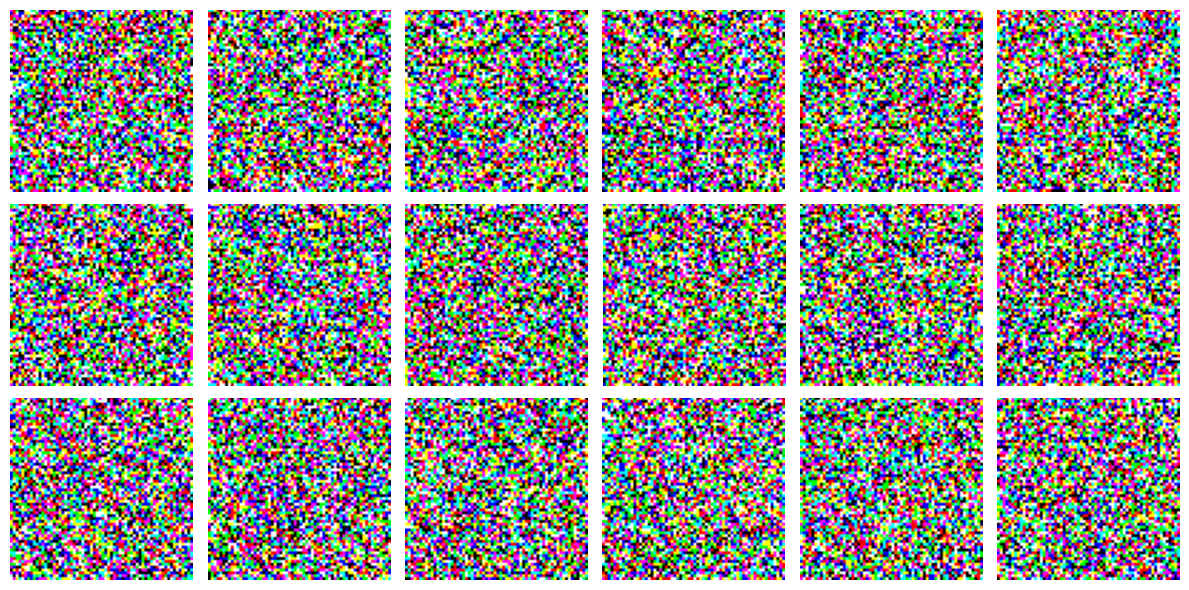

ValueError: You are saving a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.

In [ ]:
# run the training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=eval_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

# Inference

In [ ]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()

# Results

running the training for at least 50 epochs (takes 2 hours on a T4 GPU and 30 min on A100 GPU)